# The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]

Figure from Gezari (2021) ["Tidal Disruption Events", review](https://arxiv.org/abs/2104.14580)


<img src="../images/TDE.png" alt="Description" width="600" />

2. Sudden flares of active galactic nuclei

Figure from  Graham et al (2021) ["A Candidate Electromagnetic Counterpart to the Binary Black Hole Merger Gravitational Wave Event S190521ga"](https://arxiv.org/abs/2006.14122)

<img src="../images/AGN_flares.png" alt="Description" width="600" />


3. Supernovae.

Figure from  Jha et al (2019) ["Observational Properties of Thermonuclear Supernovae
"](https://arxiv.org/abs/1908.02303)

<img src="../images/SN.png" alt="Description" width="600" />



### Tasks


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [1]:
import numpy as np

data = np.load("data/transient.npy")

In [2]:
# model

def model(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
    

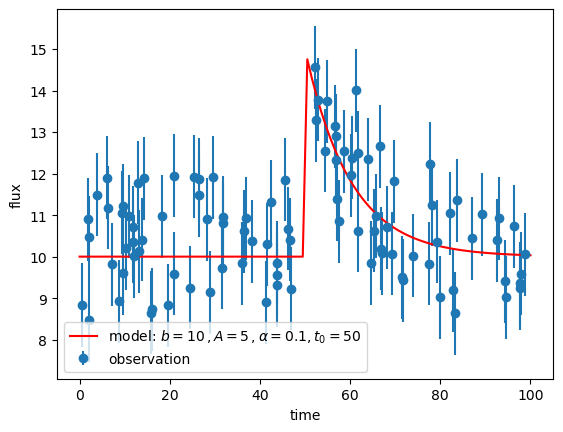

In [3]:
import matplotlib.pyplot as plt

plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None', marker='o',label='observation')
plt.xlabel("time")
plt.ylabel("flux")

times = np.linspace(0,100,100)
light_curve = model([5,10,50,0.1],times)

plt.plot(times,light_curve,c='red',label="model: $b = 10\,, A = 5\,, \\alpha = 0.1, t_0=50$")
plt.legend()
plt.show()



In [78]:
# Don't execute this cell

from scipy.stats import norm

def likelihood_gaus(data,b,A,alpha,t0): 
    return norm(loc=model(data[:,0], b, A, alpha, t0), scale=data[:,2]).pdf(data[:,1]).prod()

def priors(b,A,alpha,t0): 
    if b >= 0 and b <= 50 and A >= 0 and A <= 50 and t0 >= 0 and t0 <= 100 and alpha >= np.exp(-5) and alpha <= np.exp(5):
        return 1
    else: return 0
    

def myPosterior(data,b,A,alpha,t0):
    return likelihood_gaus(data,b,A,alpha,t0) * priors(b,A,alpha,t0)

# emcee wants ln of posterior pdf
def myLogPosterior(param, data):
    b,A,alpha,t0 = param
    return np.log(myPosterior(data,b,A,alpha,t0))



In [4]:
# It is much better to define all functions already with Log, instead of defining normal likelihood and priors and at 
# the end taking the log of their product. This second approach leads to numerical instabilities

def LogLikelihood(theta, data, model=burst):
    x, y, sigma_y = data.T
    y_fit = model(theta, x)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

## prior is proportional to 1/alpha
def Logprior(theta):
    A,b,t0,alpha=theta 
    if 0 < A < 50 and 0 < b < 50 and 0 < t0 < 100 and np.exp(-5) < alpha < np.exp(5):
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf
                   
def LogPosterior(theta,data, model=burst):
    return LogLikelihood(theta,data, model) + Logprior(theta)

In [5]:
import emcee

ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**

# initialize parameters
#starting_guesses =  np.array( [scipy.stats.uniform(loc=0,scale=50).rvs(size=nwalkers), \
#                   scipy.stats.uniform(loc=0,scale=50).rvs(size=nwalkers), \
#                   scipy.stats.uniform(loc=0,scale=100).rvs(size=nwalkers), \
#                   scipy.stats.loguniform.rvs(np.exp(-5),np.exp(5),size=nwalkers)]).T

theta_quick= np.array([5,10,50,0.1])
starting_guesses = theta_quick + 1e-1* np.random.randn(nwalkers, ndim)

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/robertoinfurna/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1467.74it/s]


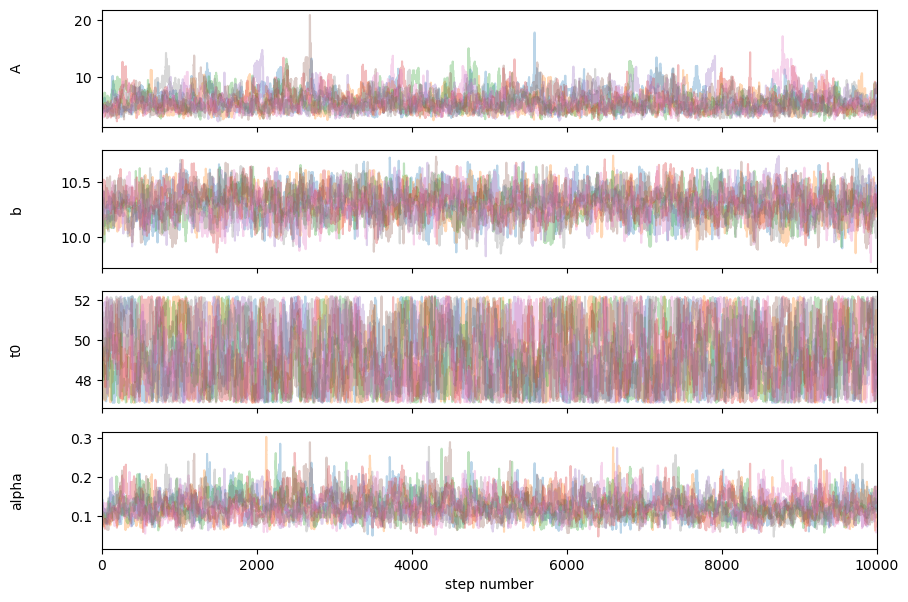

In [25]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [26]:
print(samples.shape)
emcee_trace = sampler.get_chain(discard=burn, flat=True)
emcee_trace.shape

(10000, 8, 4)


(72000, 4)

In [27]:
tau = sampler.get_autocorr_time()
print(tau)

[84.33401201 69.53826046 77.76167311 83.87798792]


In [28]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(928, 4)


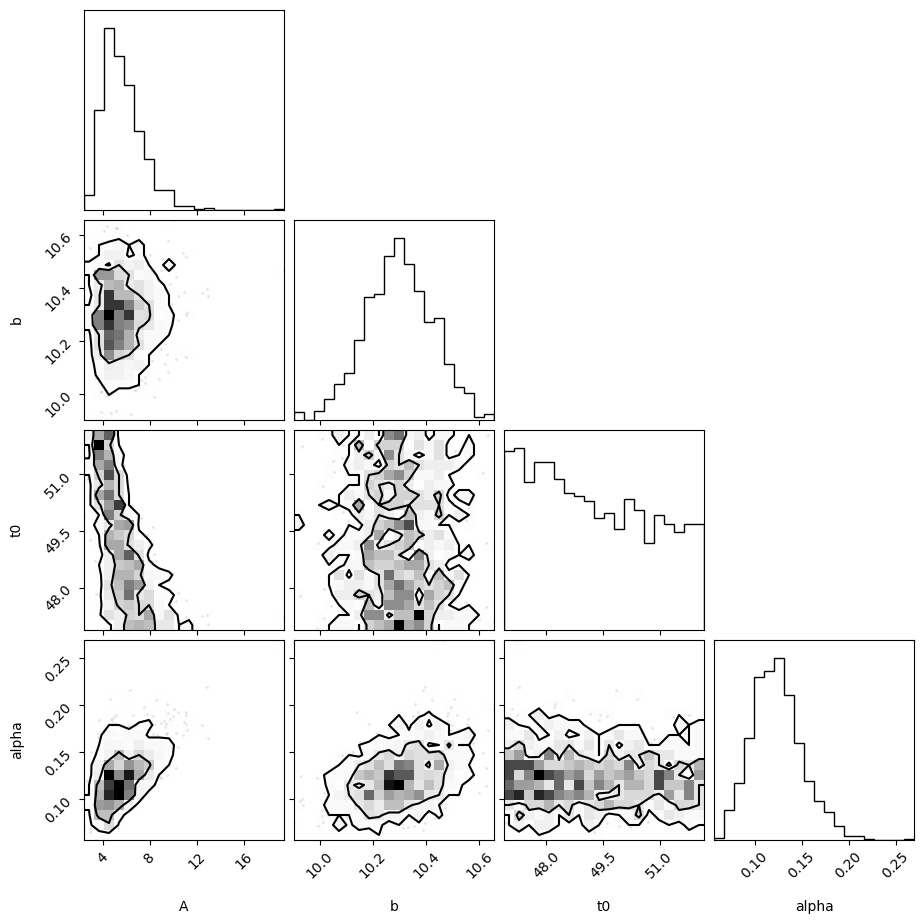

In [29]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95]
);

# Nested sampling


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [8]:
import numpy as np
from dynesty import NestedSampler
import matplotlib.pyplot as plt
import dynesty.plotting as dyplot


/tmp/ipykernel_12410/4239521390.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_12410/4239521390.py:4: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1718it [00:01, 970.82it/s, bound: 0 | nc: 32 | ncall: 15794 | eff(%): 10.878 | loglstar:   -inf < -118.037 <    inf | logz: -125.783 +/-  0.116 | dlogz: 53.071 >  0.509]  /tmp/ipykernel_12410/4239521390.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/tmp/ipykernel_12410/4239521390.py:4: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2066it [00:01, 961.21it/s, bound: 1 | nc: 1 | ncall: 18317 | eff(%): 11.279 | loglstar:   -inf < -95.041 <    inf | logz: -101.742 +/-  0.108 | dlogz: 28.211 >  0.509]  /tmp/ipykernel_12410/4239521390.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.

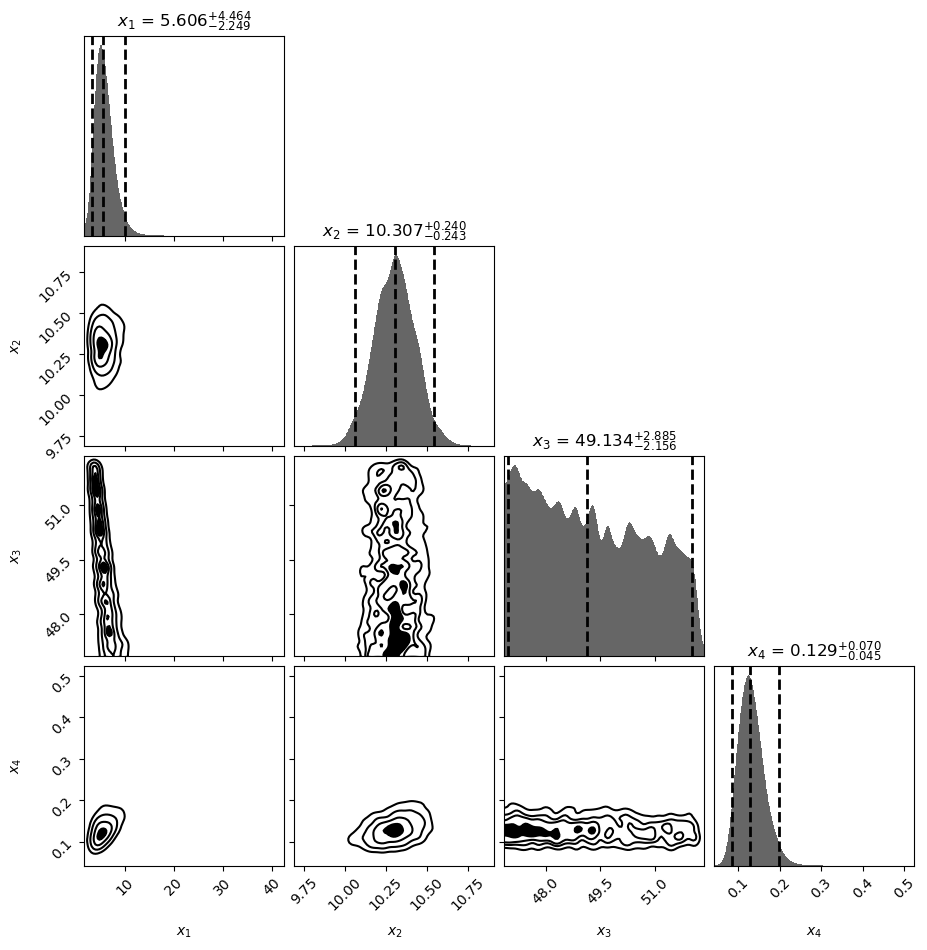

In [11]:
# ---- Model ----
def model(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))

# ---- Prior transform ----
def prior_transform(u):
    # u is in [0,1]; map to actual parameter ranges
    A = 0 + u[0] * 50       # A in [0,50]
    b = 0 + u[1] * 50       # b in [0,50]
    t0 = 0 + u[2] * 100       # t0 in [0,100] 
    alpha = np.exp(-5) + u[3] * (np.exp(5) - np.exp(-5))  #alpha in (e^-5,e^5)
    return [A, b, t0, alpha]

t = data[:,0]
flux_data = data[:,1]
err = data[:,2]

# ---- Log-likelihood ----
def log_likelihood(theta):
    y_model = model(theta, t)
    chi2 = np.sum((flux_data - y_model)**2 / err**2)
    return -0.5 * chi2

# ---- Run Nested Sampler ----
sampler = NestedSampler(log_likelihood, prior_transform, ndim=4, nlive=500)
sampler.run_nested()
results = sampler.results

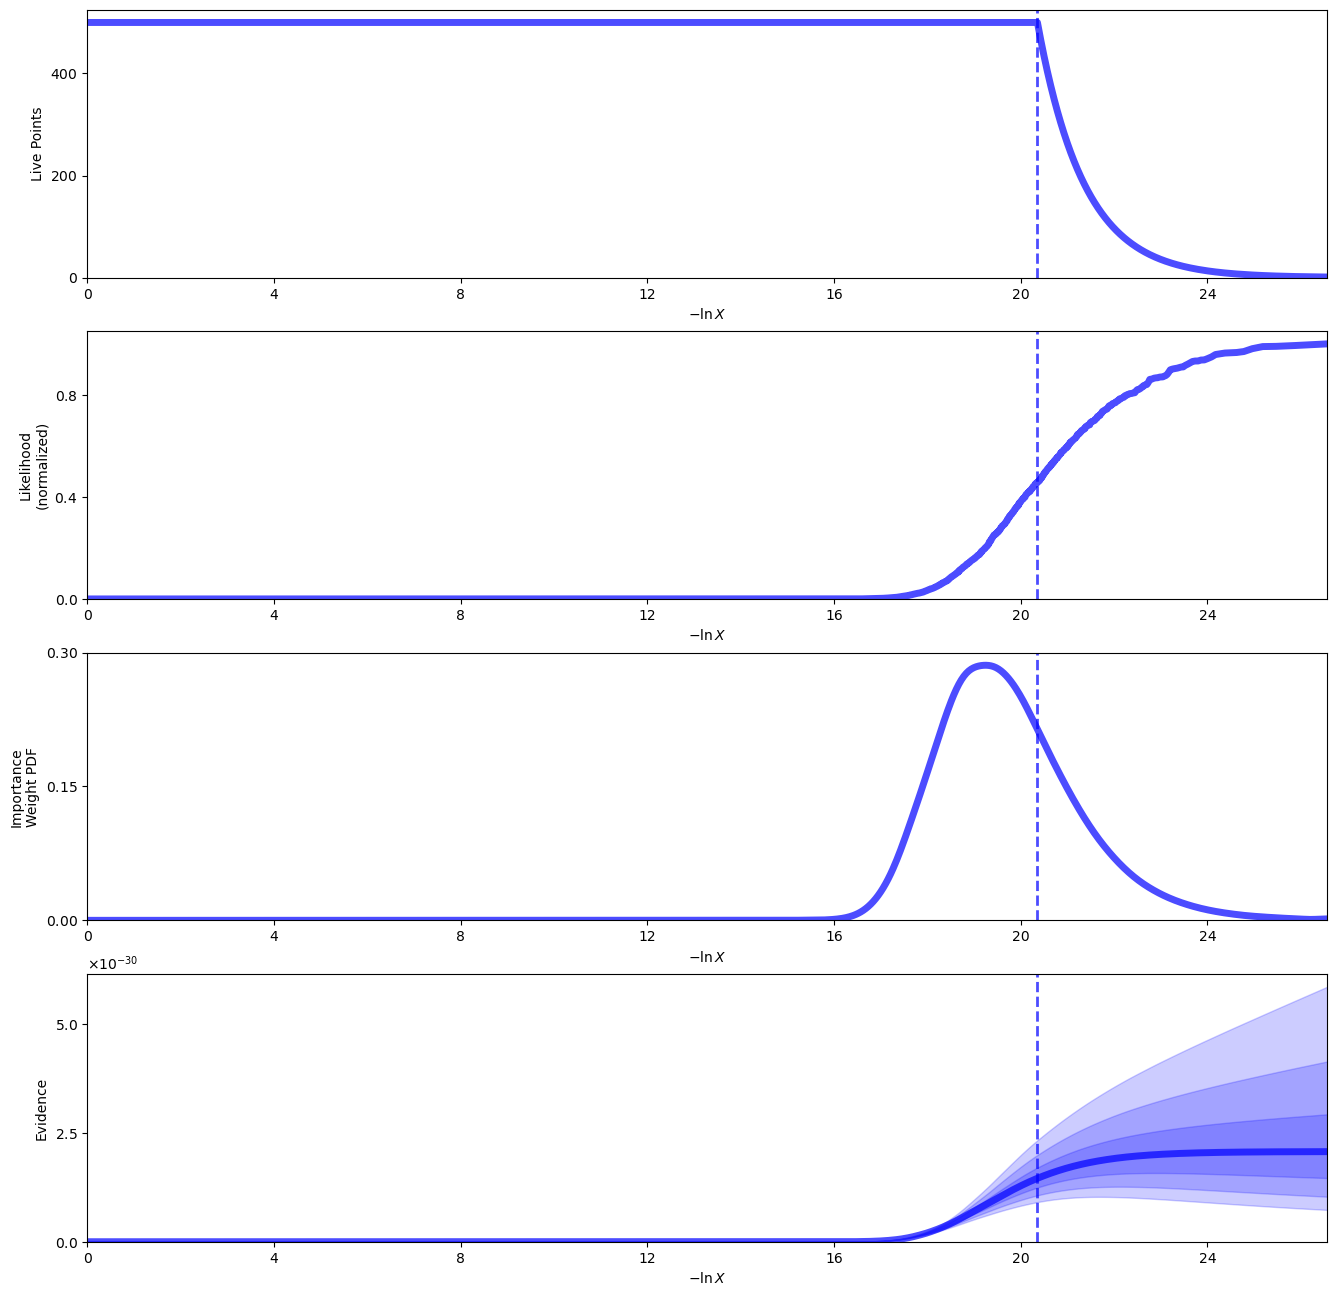

In [15]:
rfig, raxes = dyplot.runplot(results)

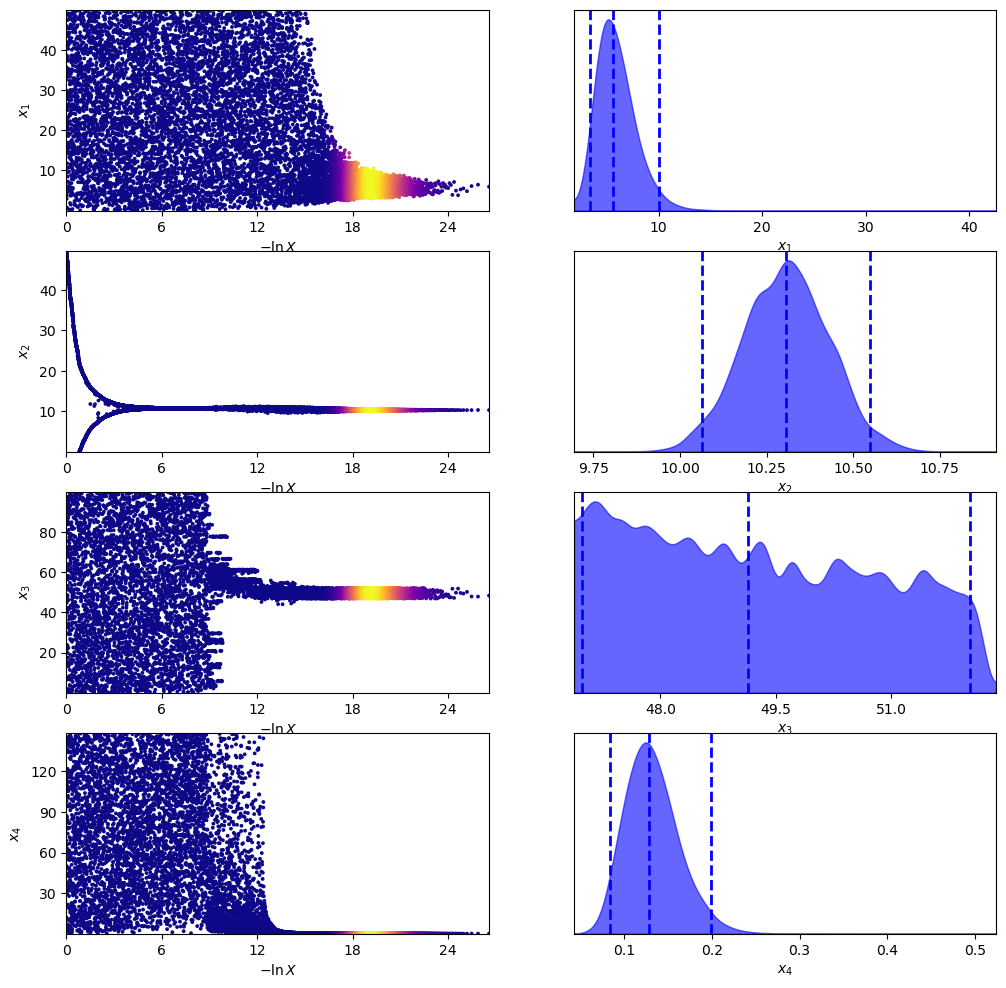

In [17]:
tfig, taxes = dyplot.traceplot(results)

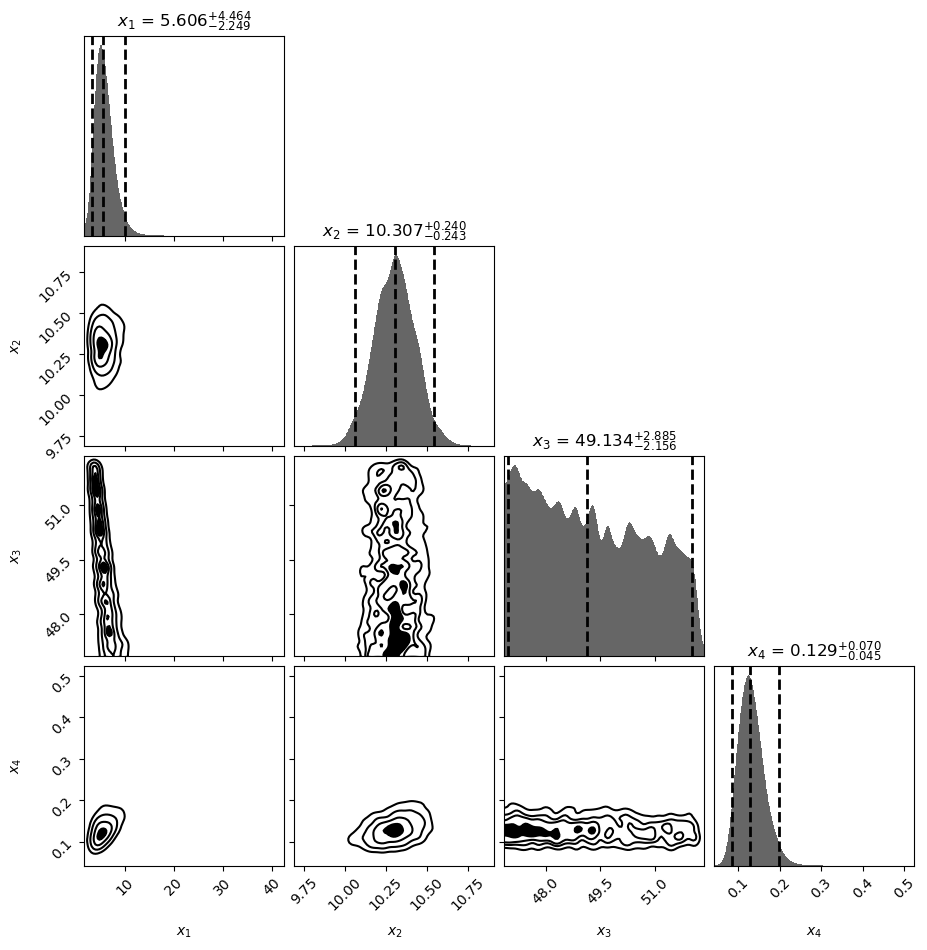

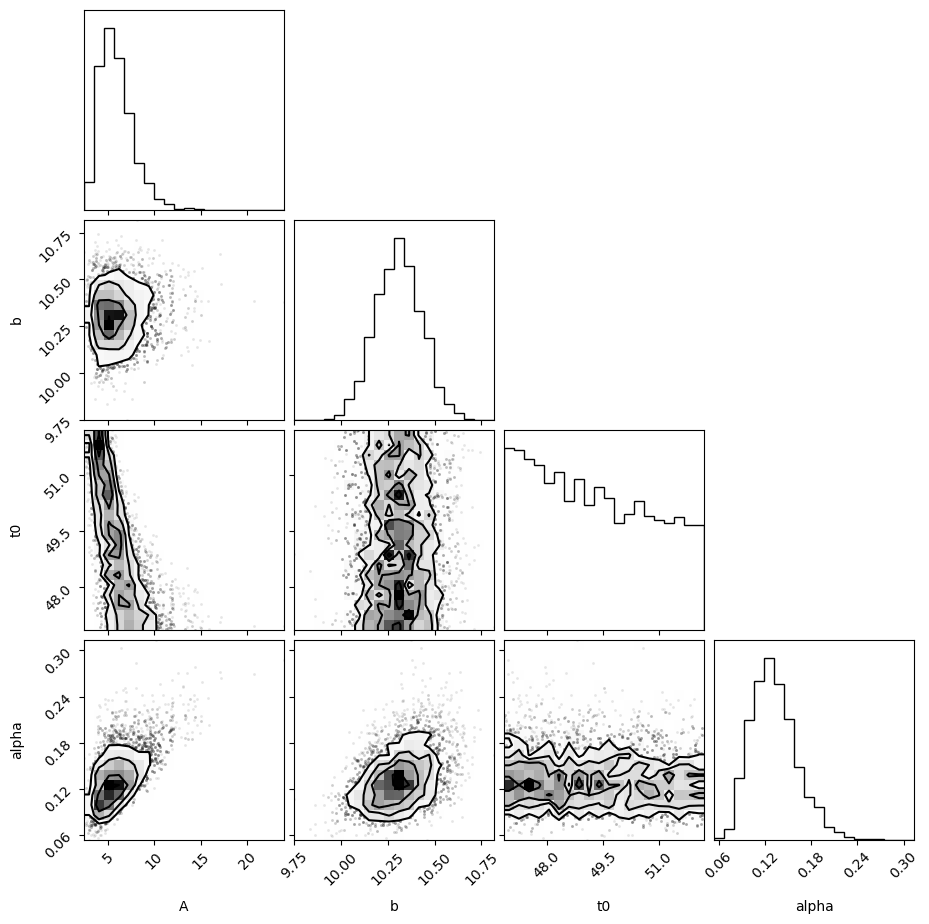

In [19]:
# ---- Plot posterior ----
fig, axes = dyplot.cornerplot(results, show_titles=True, title_fmt='.3f')
plt.show()

import corner
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);